In [1]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from plot_utils import *
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorTinguely
from preprocess_datasets import ALL_FEATURES, DEFAULT_FEATURES

from evaluate_performance import benchmark_au_roc, benchmark_warning_time

horizons = np.linspace(0.01, 0.4, 10)

device = 'cmod'
#dataset = 'random100'
dataset = 'random_256_shots_60%_flattop'
numeric_feats = ALL_FEATURES
#temporal_suff = ['_avg', '_std', '_int', '_der']
#temporal_feats = [feat + suff for feat in numeric_feats for suff in temporal_suff]

#device = 'synthetic'
#dataset = 'synthetic100'
#numeric_feats = ['ip', 'n_e', 'aminor', 'kappa', 'squareness', 'delta', 'li', 'Wmhd']
#numeric_feats = DEFAULT_FEATURES


In [2]:
# Load models and create disruption predictors

cph_model, cph_transformer = load_model('cph', device, dataset)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, numeric_feats, cph_transformer)

dcph_model, dcph_transformer = load_model('dcph', device, dataset)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, numeric_feats, dcph_transformer)

dsm_model, dsm_transformer = load_model('dsm', device, dataset)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, numeric_feats, dsm_transformer)

dcm_model, dcm_transformer = load_model('dcm', device, dataset)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, numeric_feats, dcm_transformer)

rsf_model, rsf_transformer = load_model('rsf', device, dataset)
rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, numeric_feats, rsf_transformer)

rf_model, rf_transformer = load_model('rf', device, dataset)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, numeric_feats, rf_transformer)

ting_model, ting_transformer = load_model('rf', device, dataset)
ting_predictor = DisruptionPredictorTinguely("Tinguely et al. 2019", ting_model, numeric_feats, ting_transformer)



Loaded model from models/cph_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/dcph_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/dsm_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/dcm_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/rsf_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/rf_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/rf_cmod_random_256_shots_60%_flattop.pkl


In [3]:
au_rocs_cph = benchmark_au_roc(cph_predictor, horizons, device, dataset+'_test')
#au_rocs_dcph = benchmark_au_roc(dcph_predictor, horizons, device, dataset+'_test')
au_rocs_dcm = benchmark_au_roc(dcm_predictor, horizons, device, dataset+'_test')
au_rocs_dsm = benchmark_au_roc(dsm_predictor, horizons, device, dataset+'_test')
au_rocs_rsf = benchmark_au_roc(rsf_predictor, horizons, device, dataset+'_test')
au_rocs_rf = benchmark_au_roc(rf_predictor, horizons, device, dataset+'_test')
#au_rocs_ting = benchmark_au_roc(ting_predictor, horizons, device, dataset+'_test')

#print(au_rocs_cph)
#print(au_rocs_dcph)
#print(au_rocs_dcm)
print(au_rocs_dsm)
print(au_rocs_rsf)
print(au_rocs_rf)
#print(au_rocs_ting)

[0.9005087485736022, 0.8138748296671209, 0.7606160287081339, 0.7425907784743991, 0.7332528906332874, 0.7324613798799926, 0.7254634236189385, 0.7221619306268705, 0.7158441197490669, 0.7103881414454102]
[0.9303917839482694, 0.8284950684575952, 0.7806743421052631, 0.7451149425287356, 0.7342115731409781, 0.7286784398586489, 0.7241731049132214, 0.7176571585920923, 0.7149193334921516, 0.7117007977140135]
[0.9528337771015595, 0.8364926026863928, 0.7905776515151515, 0.7622583594566353, 0.7480547894346027, 0.7445428956955262, 0.7374807052807969, 0.7328965342231293, 0.7270904470737711, 0.7182216632932492]


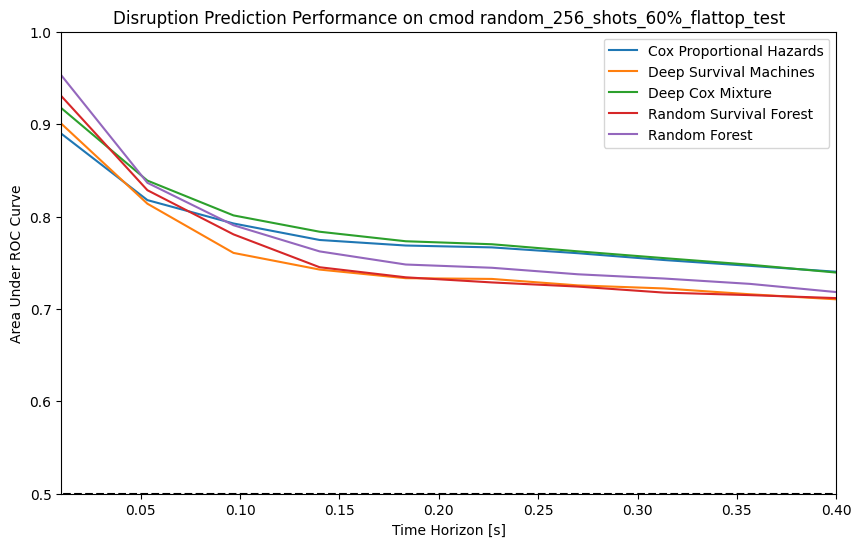

In [4]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(horizons, au_rocs_cph, label='Cox Proportional Hazards')
#plt.plot(horizons, au_rocs_dcph, label='Deep Cox Proportional Hazards')
plt.plot(horizons, au_rocs_dsm, label='Deep Survival Machines')
plt.plot(horizons, au_rocs_dcm, label='Deep Cox Mixture')
plt.plot(horizons, au_rocs_rsf, label='Random Survival Forest')
plt.plot(horizons, au_rocs_rf, label='Random Forest')
#plt.plot(horizons, au_rocs_ting, label='Tinguely et al. 2019')

#plt.plot(horizons, au_rocs_cph_temporal, label='Cox Proportional Hazards (temporal)')
#plt.plot(horizons, au_rocs_dcph_temporal, label='Deep Cox Proportional Hazards (temporal)')

# Plot horizontal line at y = 0.5 for reference to 'random guessing'
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='black')

plt.xlim([min(horizons), max(horizons)])
plt.ylim([0.5, 1.0])

plt.xlabel('Time Horizon [s]')
plt.ylabel('Area Under ROC Curve')
plt.title('Disruption Prediction Performance on '+device+' '+dataset+'_test')

plt.legend()
plt.show()



In [3]:
horizon = 0.1
amoc_cph = benchmark_warning_time(cph_predictor, horizon, device, dataset+'_test')
#amoc_dcph = benchmark_true_detection(dcph_predictor, horizon, device, dataset+'_test')
amoc_dcm = benchmark_warning_time(dcm_predictor, horizon, device, dataset+'_test')
amoc_dsm = benchmark_warning_time(dsm_predictor, horizon, device, dataset+'_test')
amoc_rsf = benchmark_warning_time(rsf_predictor, horizon, device, dataset+'_test')
amoc_rf = benchmark_warning_time(rf_predictor, horizon, device, dataset+'_test')
#amoc_ting = benchmark_true_detection(ting_predictor, horizon, device, dataset+'_test')


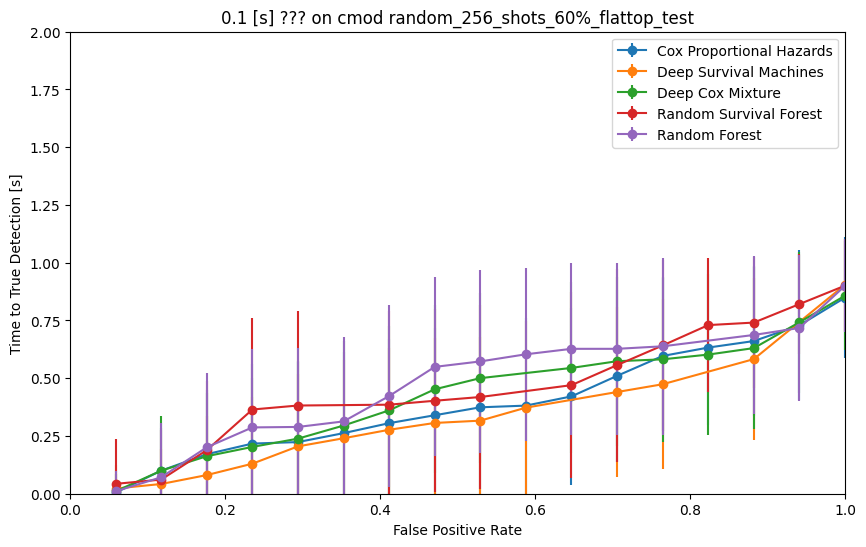

In [4]:
plt.figure(figsize=(10, 6))
plt.errorbar(amoc_cph[0], amoc_cph[1], yerr=amoc_cph[2], label='Cox Proportional Hazards', fmt='o-')
#plt.errorbar(amoc_dcph[0], amoc_dcph[1], yerr=amoc_dcph[2], label='Deep Cox Proportional Hazards', fmt='o-')
plt.errorbar(amoc_dsm[0], amoc_dsm[1], yerr=amoc_dsm[2], label='Deep Survival Machines', fmt='o-')
plt.errorbar(amoc_dcm[0], amoc_dcm[1], yerr=amoc_dcm[2], label='Deep Cox Mixture', fmt='o-')
plt.errorbar(amoc_rsf[0], amoc_rsf[1], yerr=amoc_rsf[2], label='Random Survival Forest', fmt='o-')
plt.errorbar(amoc_rf[0], amoc_rf[1], yerr=amoc_rf[2], label='Random Forest', fmt='o-')
#plt.errorbar(amoc_ting[0], amoc_ting[1], yerr=amoc_ting[2], label='Tinguely et al. 2019', fmt='o-')

plt.xlim([0, 1])
plt.ylim([0, 2])

plt.xlabel('False Positive Rate')
plt.ylabel('Warning Time [s]')
plt.title(f'Warning Time [s] with {horizon} [s] horizon on {device} {dataset}_test')

plt.legend()
plt.show()

In [ ]:
horizon = 0.1
amoc_cph = benchmark_true_detection(cph_predictor, horizon, device, dataset+'_test')
#amoc_dcph = benchmark_true_detection(dcph_predictor, horizon, device, dataset+'_test')
amoc_dcm = benchmark_true_detection(dcm_predictor, horizon, device, dataset+'_test')
amoc_dsm = benchmark_true_detection(dsm_predictor, horizon, device, dataset+'_test')
amoc_rsf = benchmark_true_detection(rsf_predictor, horizon, device, dataset+'_test')
amoc_rf = benchmark_true_detection(rf_predictor, horizon, device, dataset+'_test')
#amoc_ting = benchmark_true_detection(ting_predictor, horizon, device, dataset+'_test')


NameError: name 'benchmark_true_detection' is not defined